In [21]:
%pip install midi2audio

Note: you may need to restart the kernel to use updated packages.


In [22]:
import tensorflow as tf
from keras.layers import Input, LSTM, Dense
from keras.models import Model
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam

from typing import Dict, List, Optional, Sequence, Tuple
import collections
import datetime
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi

from IPython import display
from matplotlib import pyplot as plt
import seaborn as sns

from midi2audio import FluidSynth

In [23]:
# Creating the required variables

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [24]:
# Setting the path and loading the data

data_dir = pathlib.Path('maestro-v3.0.0-midi')

filenames = glob.glob(str(data_dir/'*/*/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1276


In [25]:
# analyzing and working with a sample file

sample_file = filenames[1]
print(sample_file)

pm = pretty_midi.PrettyMIDI(sample_file)

print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

# Extracting the notes
for i, note in enumerate(instrument.notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f'{i}: pitch={note.pitch}, note_name={note_name}, duration={duration:.4f}')

maestro-v3.0.0-midi\maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.midi
Number of instruments: 1
Instrument name: Acoustic Grand Piano
0: pitch=31, note_name=G1, duration=0.0656
1: pitch=43, note_name=G2, duration=0.0792
2: pitch=44, note_name=G#2, duration=0.0740
3: pitch=32, note_name=G#1, duration=0.0729
4: pitch=34, note_name=A#1, duration=0.0708
5: pitch=46, note_name=A#2, duration=0.0948
6: pitch=48, note_name=C3, duration=0.6260
7: pitch=36, note_name=C2, duration=0.6542
8: pitch=53, note_name=F3, duration=1.7667
9: pitch=56, note_name=G#3, duration=1.7688


In [26]:
# Extracting the notes from the sample MIDI file

def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,43,1.032292,1.111458,0.000000,0.079167
1,31,1.040625,1.106250,0.008333,0.065625
2,44,1.142708,1.216667,0.102083,0.073958
3,32,1.144792,1.217708,0.002083,0.072917
4,46,1.208333,1.303125,0.063542,0.094792


In [27]:
# Converting to note names by considering the respective pitch values

get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
print(sample_note_names[:10])

# Visualizing the paramaters of the muscial notes of the piano

def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f'First {count} notes'

        plt.figure(figsize=(20, 4))
        plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
        plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
        
        plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
        plt.xlabel('Time [s]')
        plt.ylabel('Pitch')
        _ = plt.title(title)
    else:
        title = f'Whole track'
        count = len(notes['pitch'])
        
        plt.figure(figsize=(20, 4))
        plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
        plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
        
        plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
        plt.xlabel('Time [s]')
        plt.ylabel('Pitch')
        _ = plt.title(title)

['G2' 'G1' 'G#2' 'G#1' 'A#2' 'A#1' 'C3' 'C2' 'F3' 'D4']


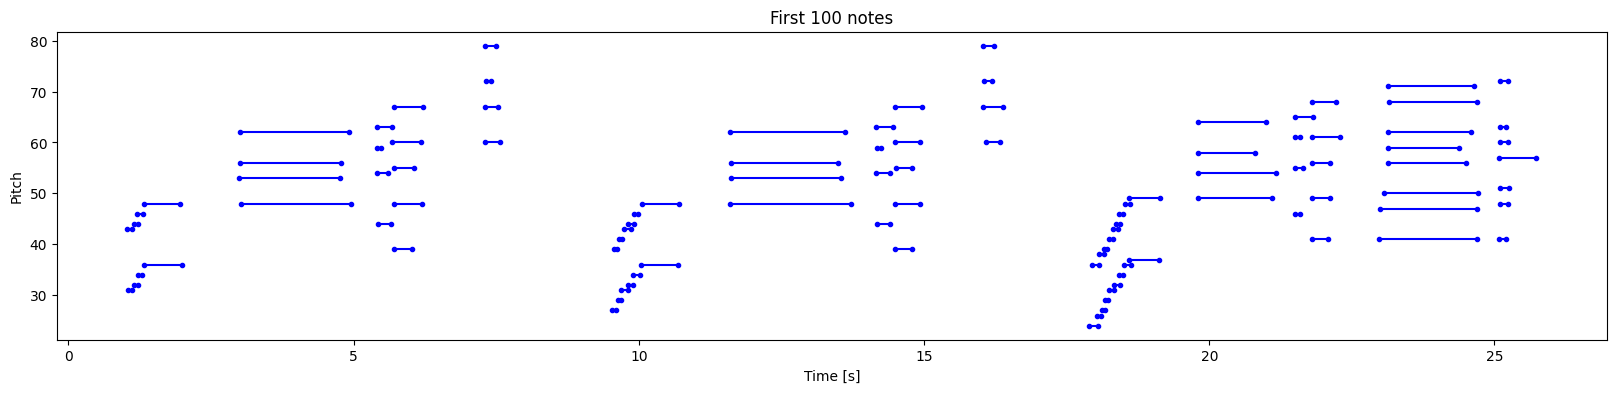

In [28]:
plot_piano_roll(raw_notes, count=100)

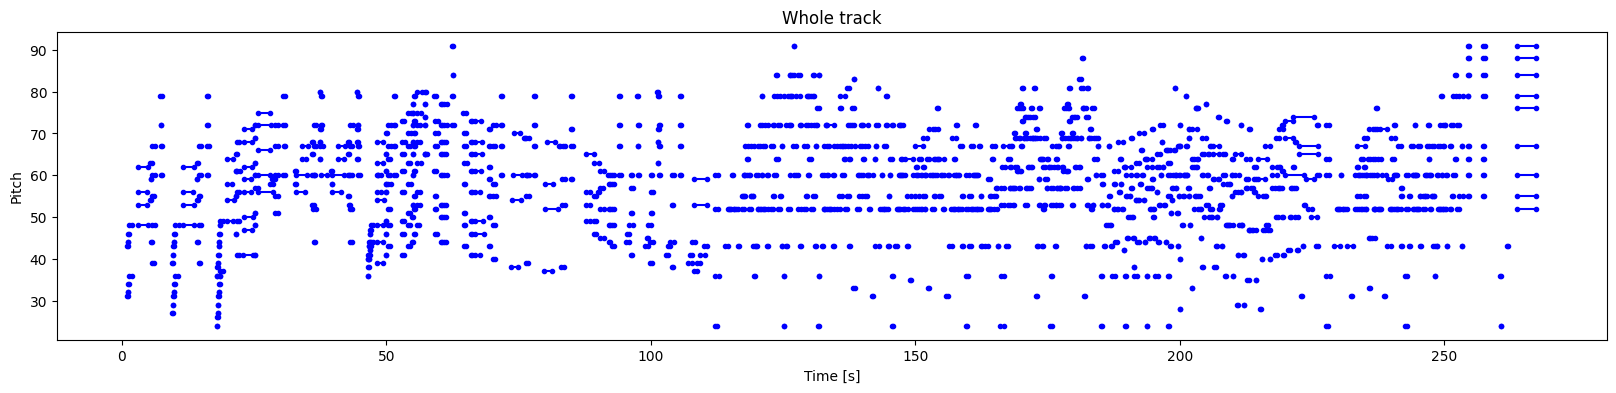

In [29]:
plot_piano_roll(raw_notes)

In [30]:
def notes_to_midi(notes: pd.DataFrame, out_file: str, instrument_name: str,
                  velocity: int = 100) -> pretty_midi.PrettyMIDI:

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        
        note = pretty_midi.Note(velocity=velocity, pitch=int(note['pitch']),
                                start=start, end=end)
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [38]:
num_files = 10
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

Number of notes parsed: 68137


TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [39]:
def create_sequences(dataset: tf.data.Dataset, seq_length: int,
                     vocab_size = 128) -> tf.data.Dataset:
    """Returns TF Dataset of sequence and label examples."""
    seq_length = seq_length+1

    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalize note pitch
    def scale_pitch(x):
        x = x/[vocab_size,1.0,1.0]
        return x

    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)
    
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)

In [40]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [41]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [42]:
# Developing the model

input_shape = (seq_length, 3)
learning_rate = 0.001

inputs = Input(input_shape)
x = LSTM(128)(inputs)

outputs = {'pitch': Dense(128, name='pitch')(x),
           'step': Dense(1, name='step')(x),
           'duration': Dense(1, name='duration')(x),
          }

model = Model(inputs, outputs)

loss = {'pitch': SparseCategoricalCrossentropy(from_logits=True),
        'step': mse_with_positive_pressure,
        'duration': mse_with_positive_pressure,
       }

optimizer = Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 128)          67584       ['input_3[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_2[0][0]']                 
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_2[0][0]']                 
                                                                                            

In [43]:
# Creating the necessary callbacks

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='./training_checkpoints/ckpt_{epoch}', save_weights_only=True),
             tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, 
                                              verbose=1, restore_best_weights=True),]

In [49]:
# Compiling and fitting the model

model.compile(loss = loss, 
              loss_weights = {'pitch': 0.05, 'step': 1.0, 'duration':1.0,},
              optimizer = optimizer,
              metrics={'pitch':'accuracy'})

epochs = 100

history = model.fit(train_ds, 
                    epochs=epochs, 
                    callbacks=callbacks,)

Epoch 1/100


1064/1064 [==============================] - 29s 24ms/step - loss: 0.2771 - duration_loss: 0.0667 - pitch_loss: 3.8142 - step_loss: 0.0197 - pitch_accuracy: 0.0538
Epoch 2/100
1064/1064 [==============================] - 26s 24ms/step - loss: 0.2724 - duration_loss: 0.0638 - pitch_loss: 3.7847 - step_loss: 0.0194 - pitch_accuracy: 0.0567
Epoch 3/100
1064/1064 [==============================] - 27s 25ms/step - loss: 0.2737 - duration_loss: 0.0646 - pitch_loss: 3.7878 - step_loss: 0.0197 - pitch_accuracy: 0.0567
Epoch 4/100
1064/1064 [==============================] - 25s 24ms/step - loss: 0.2723 - duration_loss: 0.0632 - pitch_loss: 3.7819 - step_loss: 0.0200 - pitch_accuracy: 0.0575
Epoch 5/100
1064/1064 [==============================] - 28s 26ms/step - loss: 0.2716 - duration_loss: 0.0631 - pitch_loss: 3.7839 - step_loss: 0.0194 - pitch_accuracy: 0.0560
Epoch 6/100
1064/1064 [==============================] - 25s 24ms/step - loss: 0.2694 - duration_loss: 0.0614 - pitch_loss: 3.7877 -

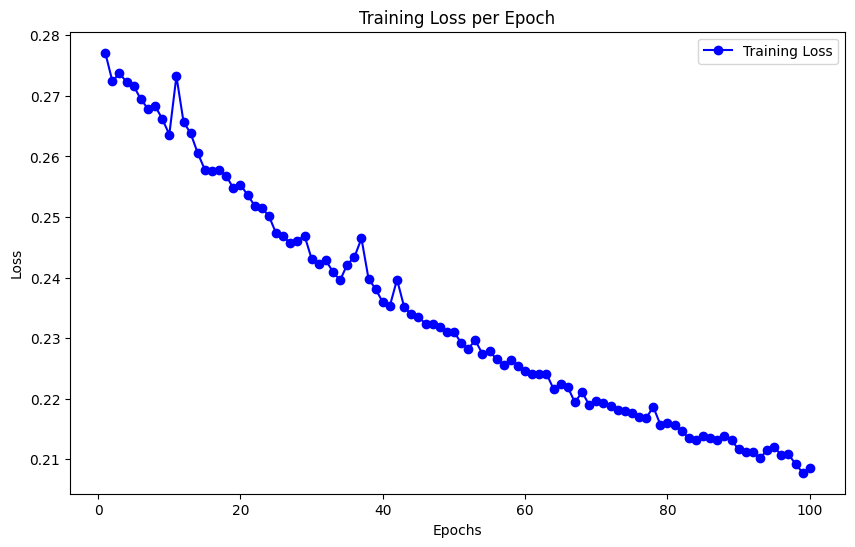

In [52]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


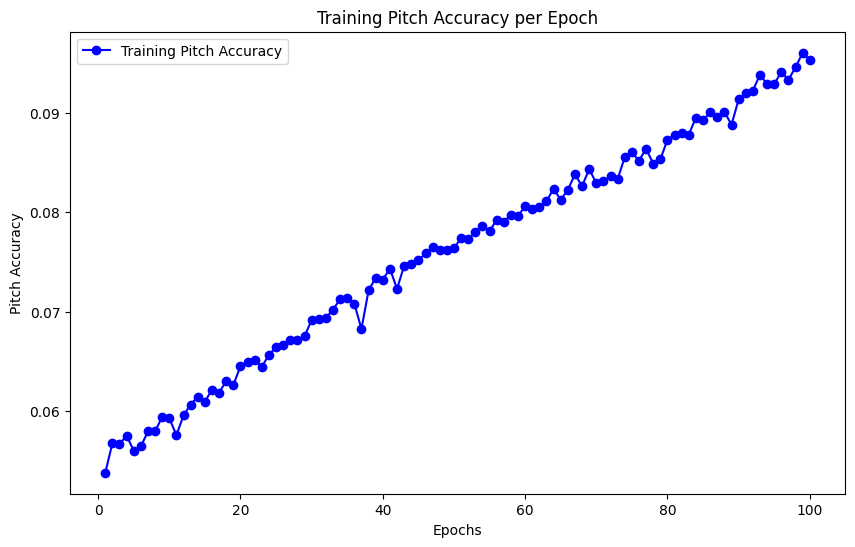

In [54]:
accuracy = history.history['pitch_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, 'bo-', label='Training Pitch Accuracy')
plt.title('Training Pitch Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Pitch Accuracy')
plt.legend()
plt.show()

In [55]:
def predict_next_note(notes: np.ndarray, keras_model: tf.keras.Model, 
                      temperature: float = 1.0) -> int:
    """Generates a note IDs using a trained sequence model."""

    assert temperature > 0

    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)

    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # `step` and `duration` values should be non-negative
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)

In [56]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes while the pitch is normalized similar to training sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0

for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

generated_notes.head(10)

1/1 [==============================] - 0s 44ms/step


,pitch,step,duration,start,end
0,84,1.595516,0.17722,1.595516,1.772737
1,94,0.594112,0.00000,2.189628,2.189628
2,78,0.530575,0.00000,2.720203,2.720203
3,85,0.515222,0.00000,3.235424,3.235424
4,82,0.505795,0.00000,3.741219,3.741219
5,57,0.510656,0.00000,4.251875,4.251875
6,85,0.509849,0.00000,4.761724,4.761724
7,42,0.497462,0.00000,5.259186,5.259186
8,85,0.484260,0.00000,5.743446,5.743446
9,74,0.531358,0.00000,6.274805,6.274805


In [66]:
out_file = 'output.midi'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)